In [19]:
import numpy as np
from scipy.spatial import distance
from scipy.stats import pearsonr

class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):

        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold   
        

    def shadow_manifold(self, X):
        X = X[:self.L] # make sure we cut at L
        M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold, here t is the time-step index in the original time series
        for t in range((self.E-1) * self.tau, self.L):
            x_lag = [] # lagged values
            for t2 in range(0, self.E-1 + 1): # dimension E
                x_lag.append(X[t-t2*self.tau])               # in each te, calculate values at column 0, 1, E    
            M[t] = x_lag
        return M # the dimension of M should be L-(E-1)*tau by E, each row is a point in the shadow manifold
    


    def get_distances(self, Mx):
        t_vec = [(k, v) for k,v in Mx.items()] #  k is the key and v is the value from the dictionary Mx
        t_steps = np.array([i[0] for i in t_vec]) # the row index
        vecs = np.array([i[1] for i in t_vec]) # the coordinates of the points in the shadow manifold
        dists = distance.cdist(vecs, vecs)    # calculate pairwise distances 
        return t_steps, dists
    


    def get_nearest_distances(self, t, t_steps, dists):

        t_ind = np.where(t_steps == t) # get the index of time t, here the index is for the points in the manifold
        dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
        
        nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
        nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
        nearest_distances = dist_t[nearest_inds]  
        
        return nearest_timesteps, nearest_distances
    


    def predict(self, t):

        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        # dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
        nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
        
        # get weights
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u) # calculated from Y
        
        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = (w * X_cor).sum() # get X_hat
        
        return X_true, X_hat
    


    def causality(self):
       
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        x, y = X_true_list, X_hat_list
        r, p = pearsonr(x, y)        

        return r, p
    

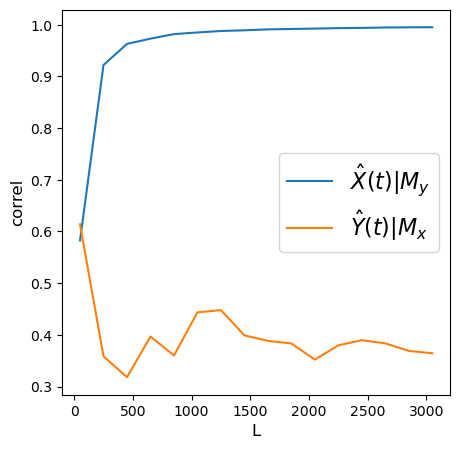

In [8]:
import matplotlib.pyplot as plt

# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.3 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 5000 # time steps


def func_bi(X, Y, r, B):
    return X*(r - r*X - B*Y)
            
def func_uni(X, Y, r, B):
    return X*(r - r*X)

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_uni(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_bi(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)  

# Looking at "convergence"
L_range = range(50, 3200, 200) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})   

(501,)
(501,)


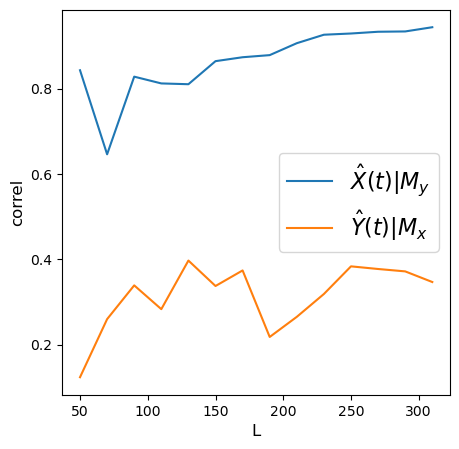

In [27]:
import matplotlib.pyplot as plt

# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.3 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 500 # time steps


def func_1(X, Y, r, B):
    return X*(r - r*X - B*Y)
            

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)  

# Looking at "convergence"
L_range = range(50, 320, 20) # L values to test
tau = 1
E = 2

# print the shape of X and Y
print(np.shape(X))
print(np.shape(Y))

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})   

In [20]:

import xarray as xr
import pandas as pd


ds_sat = xr.open_dataset('LGMR_data/ds_sat_flipped.nc')
ds_sat.info()

df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")

xarray.Dataset {
dimensions:
	lat = 96 ;
	lon = 144 ;
	age = 120 ;

variables:
	float32 lat(lat) ;
		lat:FillValue = 9.969209968386869e+36 ;
		lat:long_name = vector latitudes ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:FillValue = 9.969209968386869e+36 ;
		lon:long_name = vector of longitudes ;
		lon:units = degrees_east ;
	float32 age(age) ;
	float32 sat(age, lat, lon) ;
		sat:FillValue = 9.969209968386869e+36 ;
		sat:long_name = ENSEMBLE MEAN (n = 500) mean annual temperature at reference height ;
		sat:units = degrees Celsius ;
	float32 sat_std(age, lat, lon) ;
		sat_std:FillValue = 9.969209968386869e+36 ;
		sat_std:long_name = ENSEMBLE STANDARD DEVIATION (n = 500) mean annual temperature at reference height ;
		sat_std:units = degrees Celsius ;

// global attributes:
}

In [48]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM

# Cartopy imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def cal_raw_ccm_map_A(ds_sat, df_pre, E, tau, Tp,v_rage='auto',show_plot=True):
    """
    Compute and plot a global map of CCM skill using pyEDM's CCM.
    
    Parameters:
        E (int): Embedding dimension for CCM.
        tau (int): Time delay.
        Tp (int): Prediction horizon.
    
        ds_sat: xarray Dataset containing "sat", "lat", "lon", and "age".
        df_pre: pandas DataFrame with column "pre".
    """
    
    # Make sure the time series lengths match
    assert len(df_pre) == ds_sat.sizes["age"], "Timeseries length mismatch"

    # ------------------------------------------------
    # Prepare the grid and output array
    # ------------------------------------------------
    nlat = ds_sat.sizes["lat"]
    nlon = ds_sat.sizes["lon"]
    ages = ds_sat["age"].values
    rho_map = np.full((nlat, nlon), np.nan)
    
    # CCM parameter: library sizes (this could also be made an input if desired)
    # libSizes = "10 20 30 40 50 60 70 80"
    L_range=range(20, 80, 10)
    
    # ------------------------------------------------
    # Loop over all lat/lon grid points and compute CCM skill
    # ------------------------------------------------
    for iLat in range(nlat):
        for iLon in range(nlon):
            # Extract the local "sat" time series
            sat_ts = ds_sat["sat"].isel(lat=iLat, lon=iLon).values

            # # Build temporary DataFrame for CCM (predicting "X" using "Y")
            # temp_df = pd.DataFrame({
            #     "Time": ages*-1,
            #     "X": df_pre["pre"],  # target (what we want to predict)
            #     "Y": sat_ts,         # predictor
            # })

            X=df_pre["pre"].values
            Y=sat_ts

            # # print the shape of X and Y
            # print(np.shape(X))
            # print(np.shape(Y))

            Xhat_My, Yhat_Mx = [], [] # correlation list
            for L in L_range: 
                ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
                # ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
                Xhat_My.append(ccm_XY.causality()[0]) 
                # Yhat_Mx.append(ccm_YX.causality()[0]) 
            rho_at_largest=max(Xhat_My)
            rho_map[iLat, iLon] = rho_at_largest


            # # Run CCM (Y -> X)
            # ccm_out = CCM(
            #     dataFrame   = temp_df,
            #     E           = E,
            #     tau         = tau,
            #     columns     = "Y",
            #     target      = "X",
            #     libSizes    = libSizes,
            #     sample      = 10,
            #     random      = True,
            #     replacement = False,
            #     Tp          = Tp
            # )

            # # Extract the mean CCM skill at the largest library size
            # largest_L = ccm_out["LibSize"].max()
            # mask_last = ccm_out["LibSize"] == largest_L
            # rho_at_largest = ccm_out.loc[mask_last, "Y:X"].mean()
            # rho_map[iLat, iLon] = rho_at_largest

    # ------------------------------------------------
    # Plot the global map using Cartopy (Robinson projection)
    # ------------------------------------------------
    lats = ds_sat["lat"].values
    lons = ds_sat["lon"].values
    # lats = np.array(ds_sat["lat"].values, dtype=np.float64)
    # lons = np.array(ds_sat["lon"].values, dtype=np.float64)

    if show_plot:
        fig = plt.figure(figsize=(11, 6))
        ax = plt.axes(projection=ccrs.Robinson())
        pcm = ax.pcolormesh(
            lons, lats, rho_map,
            transform=ccrs.PlateCarree(),  # data in lat/lon
            shading="auto"
        )
        ax.coastlines()
        
        if v_rage == 'auto':
            vmin, vmax = np.nanmin(rho_map), np.nanmax(rho_map)
        else:
            vmin, vmax = v_rage
        
        pcm.set_clim(vmin, vmax)
        cb = plt.colorbar(pcm, orientation="horizontal", pad=0.07, shrink=0.8)
        cb.set_label(r"CCM skill $\rho$ (\hat{Pre}$|$M_{sat})")

        
        plt.show()

    return rho_map

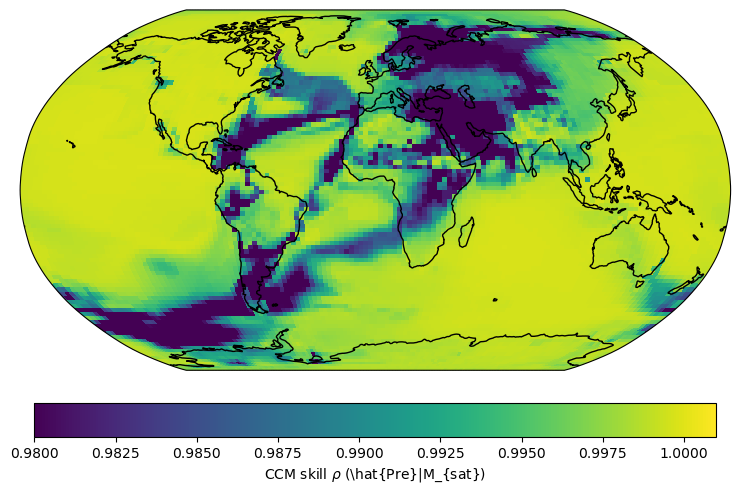

In [49]:
rwa_rho_map_Tp0=cal_raw_ccm_map_A(ds_sat=ds_sat, df_pre= df_pre, E=4, tau=3, Tp=0,v_rage=[0.98,1.001],show_plot=True)